<a href="https://colab.research.google.com/github/Dil99818/Transfer_learning01/blob/main/Scaling_Up_Transfer_Learning_with.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning_with_tensorflow_for_Scaling_Up

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2022-06-14 07:03:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  62.4MB/s    in 13s     

2022-06-14 07:04:05 (123 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [2]:
def unzip_file(url):
  import zipfile
  zip_ref= zipfile.ZipFile(url)
  zip_ref.extractall()

unzip_file("101_food_classes_10_percent.zip")

In [3]:
train_data= "101_food_classes_10_percent/train/"
test_data="101_food_classes_10_percent/test/"

In [4]:
def walk_through_directory(data_url):
  import os
  for dirictory_Path, number_diricotry, file_name in os.walk(data_url):
    print(f"Number_of_Dirictory: {len(number_diricotry)}, Number of File: {len(file_name)}, dirictory_Path: {dirictory_Path}, ")

#walk_through_directory("101_food_classes_10_percent")

In [5]:
#Set the data input
import tensorflow as tf

train_data_for_input= tf.keras.preprocessing.image_dataset_from_directory(train_data,
                                                                          label_mode="categorical",
                                                                          image_size=(224,224))
                                                                          
test_data_for_input=tf.keras.preprocessing.image_dataset_from_directory(test_data,
                                                                        label_mode="categorical",
                                                                        image_size=(224,224),
                                                                        shuffle= False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
len(test_data_for_input.class_names)

101

In [7]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2), 
  preprocessing.RandomWidth(0.2), 

], name="data_augmentation")

In [8]:
for layers in data_augmentation.layers[:1]:
  print(layers)

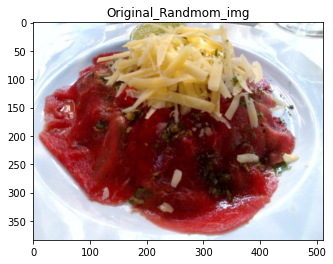

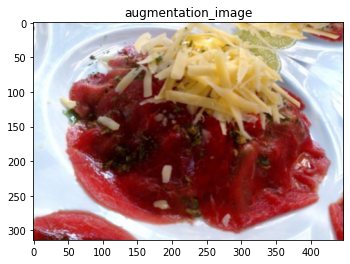

In [9]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

target_class= random.choice(train_data_for_input.class_names)
target_dir= "101_food_classes_10_percent/train/" + target_class
target_image= random.choice(os.listdir(target_dir))
target_image_path= target_dir + "/" + target_image
img = mpimg.imread(target_image_path)

plt.imshow(img);
plt.title("Original_Randmom_img")

plt.figure()
aug_img=data_augmentation(img)
plt.imshow(aug_img/255.);
plt.title("augmentation_image");

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape= (224,224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights

x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_for_input.class_names), activation="softmax", name="output_layer")(x) 
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
#Create the checkPoint Path 
checkpoint_path= "101_class_10precent_model_checkpoint"

checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        monitor="val_accuracy") 

In [13]:
#Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [14]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # useing Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_for_input,
                                           epochs=5, # fit for 5 epochs 
                                           validation_data=test_data_for_input,
                                           validation_steps=int(0.15 * len(test_data_for_input)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 91s 305ms/step - loss: 3.3988 - accuracy: 0.2639 - val_loss: 2.5670 - val_accuracy: 0.4306
Epoch 2/5
237/237 [==============================] - 61s 254ms/step - loss: 2.2286 - accuracy: 0.4873 - val_loss: 2.1380 - val_accuracy: 0.4889
Epoch 3/5
237/237 [==============================] - 58s 245ms/step - loss: 1.8361 - accuracy: 0.5703 - val_loss: 2.0131 - val_accuracy: 0.4971
Epoch 4/5
237/237 [==============================] - 55s 231ms/step - loss: 1.6186 - accuracy: 0.6062 - val_loss: 1.9152 - val_accuracy: 0.5124
Epoch 5/5
237/237 [==============================] - 52s 218ms/step - loss: 1.4622 - accuracy: 0.6490 - val_loss: 1.9141 - val_accuracy: 0.5021


In [15]:
feature_exterction_result= model.evaluate(test_data_for_input)
feature_exterction_result

790/790 [==============================] - 94s 119ms/step - loss: 1.6491 - accuracy: 0.5711


[1.649124026298523, 0.5711287260055542]

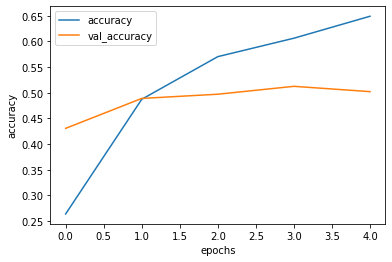

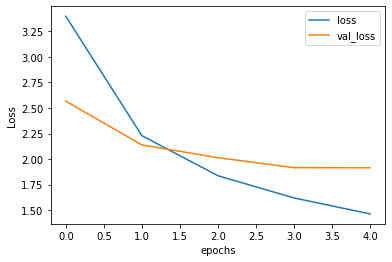

In [16]:
def plot_the_history(model_history):
    
    import matplotlib.pyplot as plt
    
    accuracy=model_history.history['accuracy']
    val_accuracy=model_history.history['val_accuracy']
    
    loss=model_history.history['loss']
    val_loss=model_history.history['val_loss']
    
    epochs= range(len(model_history.history['loss']))
    
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend();
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    
    plt.figure()
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend();
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    
plot_the_history(history_all_classes_10_percent)

In [17]:
base_model.trainable = True

for layers in base_model.layers[:-5]:
  layers.trainable=False

#let see - last 5 layers must be trainable 
#for i, layers in enumerate(base_model.layers):
    #print(i, layers.name, layers.trainable)

In [18]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [19]:
for layers in model.layers[:2]:
  print(layers)

In [20]:
history_all_classes_10_percent.epoch[-1]

4

In [21]:
initial_epochs= 10
history_model1_finetune= model.fit(train_data_for_input,
                                   epochs=initial_epochs,
                                   validation_data= test_data_for_input,
                                   validation_steps=int(0.20* len(test_data_for_input)),
                                   initial_epoch= history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 69s 258ms/step - loss: 1.2114 - accuracy: 0.6871 - val_loss: 1.8787 - val_accuracy: 0.5085
Epoch 6/10
237/237 [==============================] - 56s 235ms/step - loss: 1.0680 - accuracy: 0.7205 - val_loss: 1.8758 - val_accuracy: 0.5117
Epoch 7/10
237/237 [==============================] - 54s 227ms/step - loss: 0.9919 - accuracy: 0.7381 - val_loss: 1.8574 - val_accuracy: 0.5164
Epoch 8/10
237/237 [==============================] - 53s 222ms/step - loss: 0.9272 - accuracy: 0.7543 - val_loss: 1.8597 - val_accuracy: 0.5194
Epoch 9/10
237/237 [==============================] - 55s 229ms/step - loss: 0.8600 - accuracy: 0.7716 - val_loss: 1.8673 - val_accuracy: 0.5174
Epoch 10/10
237/237 [==============================] - 54s 226ms/step - loss: 0.8093 - accuracy: 0.7828 - val_loss: 1.9097 - val_accuracy: 0.5075


In [22]:
finetune_evaluate =  model.evaluate(test_data_for_input) #Last time it was 56 Precent

790/790 [==============================] - 94s 119ms/step - loss: 1.5541 - accuracy: 0.5911


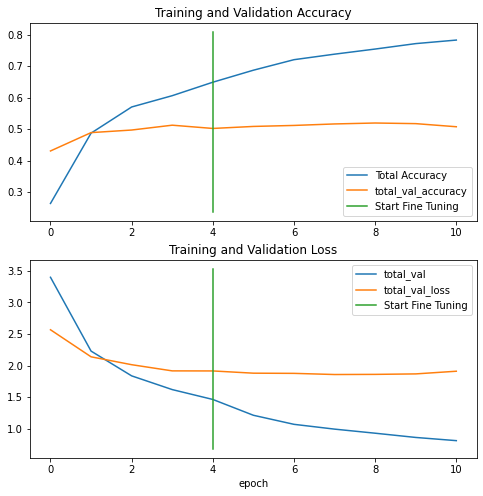

In [23]:
def plot_history_for_finetune(original_history, new_history, initial_epochs=5):
    
    import matplotlib.pyplot as plt
    
    accuracy=original_history.history["accuracy"]
    loss=    original_history.history['loss']
    
    val_accuracy= original_history.history["val_accuracy"]
    val_loss=     original_history.history["val_loss"]
    
    total_accuracy=accuracy + new_history.history['accuracy']
    total_loss=    loss     + new_history.history['loss']
    
    total_val_accuracy= val_accuracy + new_history.history['val_accuracy']
    total_val_loss=     val_loss     + new_history.history["val_loss"]
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    
    plt.plot(total_accuracy, label="Total Accuracy")
    plt.plot(total_val_accuracy, label="total_val_accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="total_val")
    plt.plot(total_val_loss, label="total_val_loss")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

plot_history_for_finetune(history_all_classes_10_percent, 
                 new_history=history_model1_finetune, 
                 initial_epochs=5)


In [24]:
# Download pre-trained model from Google Storage

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"

--2022-06-14 07:21:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   143MB/s    in 0.3s    

2022-06-14 07:21:46 (143 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [25]:
import zipfile
zip_ref= zipfile.ZipFile(saved_model_path)
zip_ref.extractall()

In [26]:
model = tf.keras.models.load_model(saved_model_path.split(".")[0])

In [27]:
finetune_evaluate = model.evaluate(test_data_for_input)

790/790 [==============================] - 100s 125ms/step - loss: 1.8027 - accuracy: 0.6078


In [28]:
#making predictions with model
model_predict= model.predict(test_data_for_input, verbose=1)

790/790 [==============================] - 91s 113ms/step


In [29]:
#len(test_data_for_input.class_names), len(model_predict), model_predict.shape, len(test_data_for_input), model_predict.shape, model_predict[0].argmax(), 

In [30]:
model_predict[25249], len(model_predict[25249])

(array([3.13634165e-02, 7.50528323e-03, 4.29749518e-04, 1.36518565e-08,
        1.03165912e-05, 3.05589998e-09, 4.69296538e-05, 1.56150821e-11,
        5.42645459e-04, 5.42010014e-07, 4.86278586e-04, 1.45596457e-09,
        2.68921558e-05, 2.13489685e-07, 1.13508868e-04, 1.78643219e-07,
        1.55008840e-03, 2.27503537e-04, 6.32391993e-06, 2.24107280e-05,
        1.35689520e-03, 4.93967636e-05, 1.92305903e-04, 1.07843347e-03,
        3.84836349e-05, 8.10900310e-05, 1.25130214e-06, 1.24080032e-07,
        1.10774417e-05, 5.56723059e-08, 8.75788970e-08, 6.47303881e-03,
        5.75316108e-07, 3.80869011e-07, 3.10622061e-09, 6.16699197e-07,
        2.93411335e-06, 4.13332018e-05, 1.80269501e-06, 7.99169124e-04,
        5.96724171e-03, 3.53331120e-06, 3.56716732e-03, 6.15309204e-07,
        8.43002945e-10, 3.28934604e-08, 1.73285793e-04, 1.46828213e-04,
        3.53590109e-11, 3.11934631e-02, 5.42358321e-04, 2.47667970e-07,
        3.95903774e-02, 1.37291252e-04, 3.13539523e-08, 6.134721

In [31]:
#predicted class index for each of the samples in our test dataset.
model_predict_class=model_predict.argmax(axis=1)  # predicted class index for each of the samples in our test dataset.

model_predict_class[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [32]:

y_labels=[]
for image, layers in test_data_for_input.unbatch(): #unbatch the test data and get images and labels
  y_labels.append(layers.numpy().argmax()) #append the index which has the largest value (labels are one-hot)

y_labels[:10]# check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
#Evaluating our models predictions
from sklearn.metrics import accuracy_score
sklearn_accuracy= accuracy_score(y_labels, model_predict_class)
sklearn_accuracy

0.6077623762376237

In [34]:
import numpy as np
np.isclose(finetune_evaluate[1], sklearn_accuracy)

True

In [35]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")

  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
      
# Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

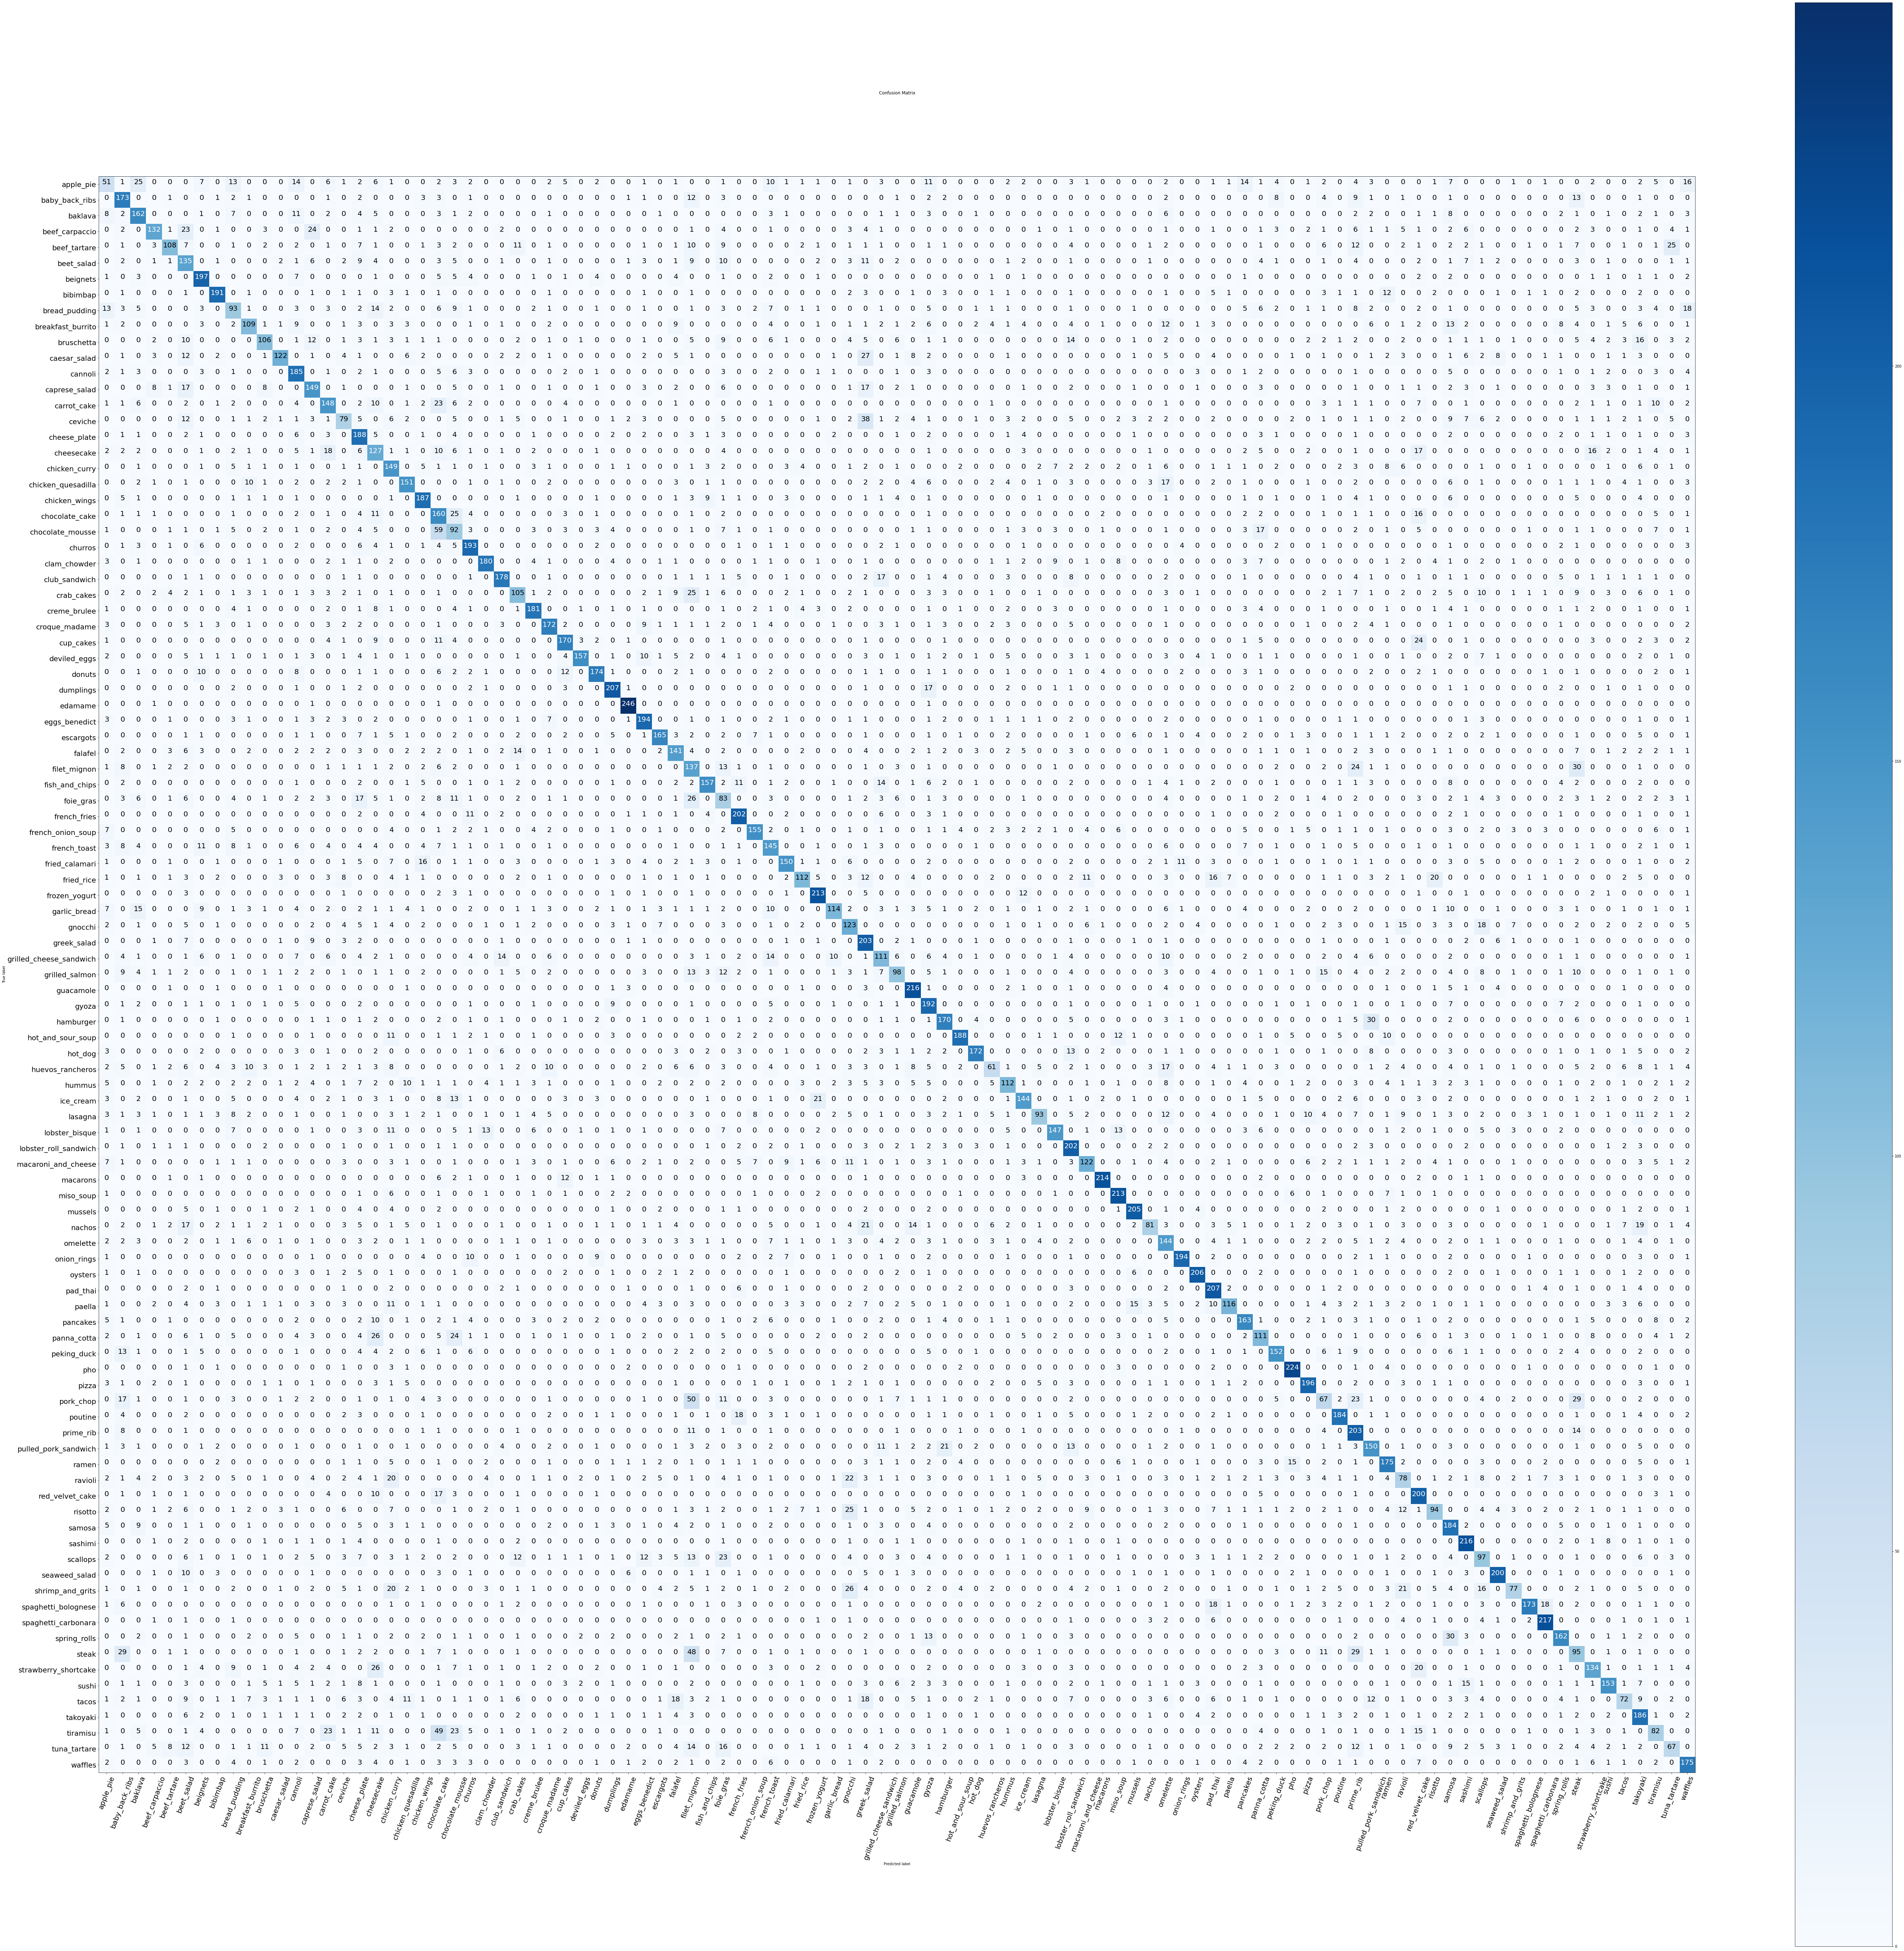

In [36]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=model_predict_class,
                      classes=test_data_for_input.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, model_predict_class))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [38]:
# Get a dictionary of the classification report
classification_report_dict= classification_report(y_labels, model_predict_class, output_dict= True) 
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [39]:
#Create empty dictionary
class_f1_score={}

#loop through classifications_report item
for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_score[test_data_for_input.class_names[int(k)]] = v["f1-score"]

class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [40]:
import pandas as pd #classification_report
f1_scores= pd.DataFrame({"class_name": list(class_f1_score.keys()),
                       "f1_score": list(class_f1_score.values())}).sort_values("f1_score", ascending= False) 

f1_scores

class_name  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [41]:
range(len(f1_scores))  

range(0, 101)

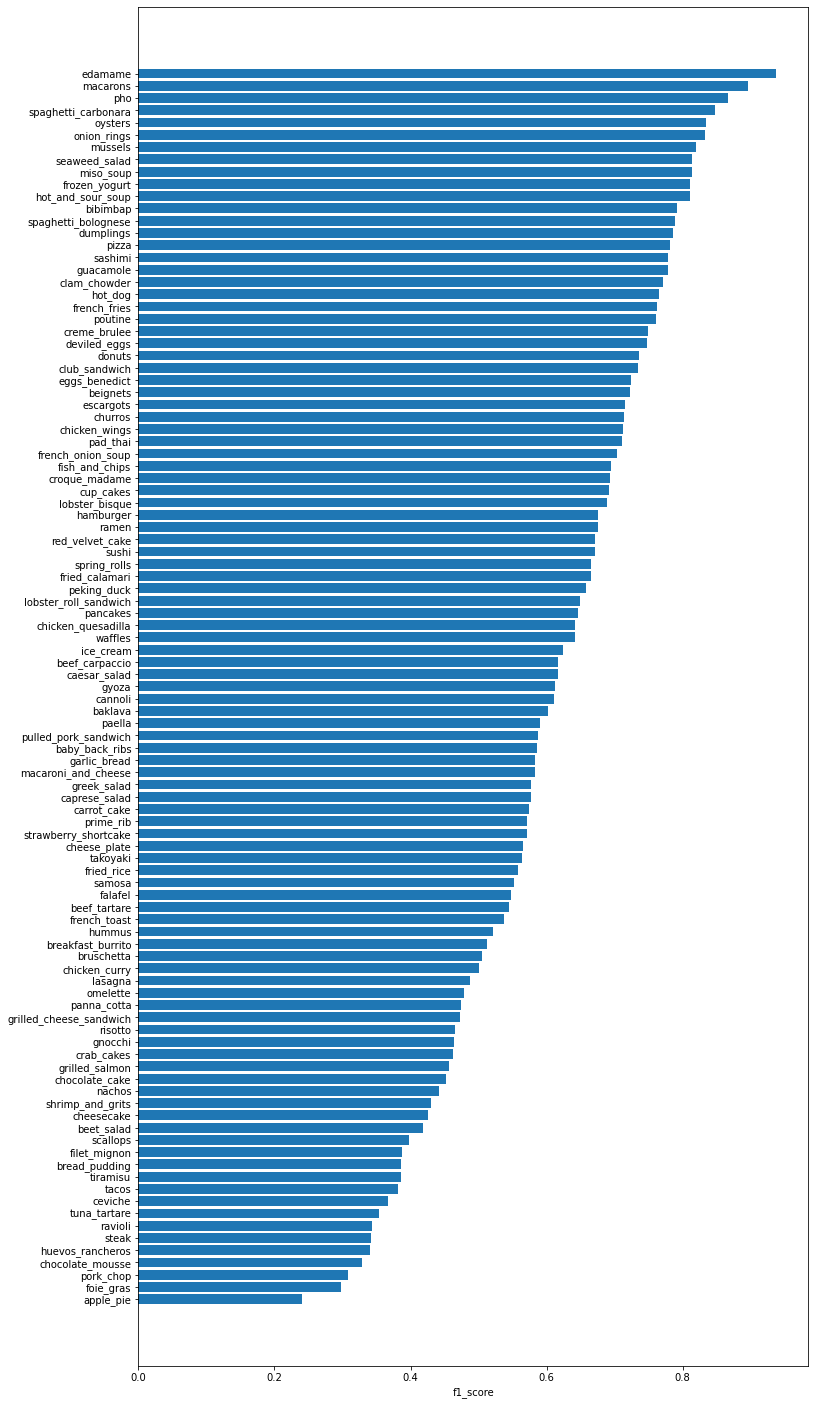

In [42]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_name"])

ax.set_xlabel("f1_score")
ax.invert_yaxis();


In [296]:
class_names= test_data_for_input.class_names

In [43]:
def load_and_pred_image(filename, img_shape=224, scale=True):

  #Read the image
  img=tf.io.read_file(filename)

  #Decode it inti the tensor
  img=tf.io.decode_image(img)

  #Resize the image
  img= tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  
  else:
    return img


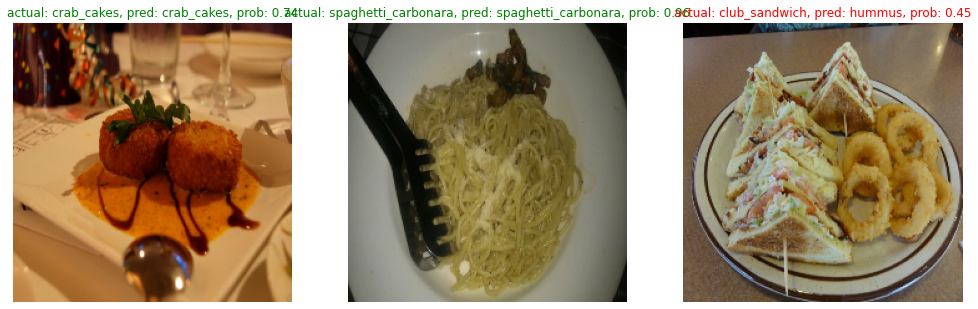

In [53]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_data + "/" + class_name))
  filepath = test_data + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [63]:
#Try to find most wrong predictions
import numpy as np

#1. Get all of the image file path in the test Data
filepaths = []

for filepath in test_data_for_input.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())


In [69]:
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [150]:
model_predict_list = model_predict.max(axis=1)
model_predict_list = model_predict_list.tolist()

In [179]:
#Create the dataFrame out of the current prediction data for analysis 

import pandas as pd 

pred_df= pd.DataFrame({"img_path" : filepaths,
                       "y_true": y_labels,
                       "y_pred": model_predict_class,
                       "y_true_class_name": [class_names[i] for i in y_labels],
                       "Y_pred_class_name": [class_names[i] for i in model_predict_class],
                       "Model_prediction" : model_predict.max(axis=1)
                       })


In [180]:
pred_df[:10]

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
5  b'101_food_classes_10_percent/test/apple_pie/1...       0      61   
6  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   
7  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
8  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
9  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   

  y_true_class_name      Y_pred_class_name  Model_prediction  
0         apple_pie                  gyoza          0.847418  
1         apple_pie              apple_pie          0.964017  
2         apple_pie              apple_pie          0.959259  
3         apple_pie   pulled_pork_sandwich          0.658607  
4         apple_pie              prime_rib          0.367900  
5         apple_pie  lobster_roll_sandwich          0.456755  
6         apple_pie              cup_cakes          0.611242  
7         apple_pie              apple_pie          0.473132  
8         apple_pie                 samosa          0.245397  
9         apple_pie              apple_pie          0.724390

In [181]:
#Find out with predicition are wrong on DataFrame

pred_df["pred_corrent"] = pred_df["y_true"] == pred_df["y_pred"]

pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

  y_true_class_name     Y_pred_class_name  Model_prediction  pred_corrent  
0         apple_pie                 gyoza          0.847418         False  
1         apple_pie             apple_pie          0.964017          True  
2         apple_pie             apple_pie          0.959259          True  
3         apple_pie  pulled_pork_sandwich          0.658607         False  
4         apple_pie             prime_rib          0.367900         False

In [193]:
# 4. Get the top 100 wrong examples
top_100_wrong_exp = pred_df[pred_df["pred_corrent"] == False].sort_values("Model_prediction", ascending=False)[:100]
top_100_wrong_exp.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

           y_true_class_name      Y_pred_class_name  Model_prediction  \
21810               scallops              cup_cakes          0.999997   
231                apple_pie                waffles          0.999995   
15359  lobster_roll_sandwich              hamburger          0.999988   
23539   strawberry_shortcake        red_velvet_cake          0.999987   
21400                 samosa           spring_rolls          0.999981   
24540               tiramisu        red_velvet_cake          0.999947   
2511              bruschetta  lobster_roll_sandwich          0.999945   
5574        chocolate_mousse         chocolate_cake          0.999939   
17855                 paella                mussels          0.999931   
23797                  sushi                sashimi          0.999904   
18001               pancakes               omelette          0.999904   
11642           garlic_bread             bruschetta          0.999877   
10847         fried_calamari            onion_rings          0.999872   
23631   strawberry_shortcake        red_velvet_cake          0.999858   
1155            beef_tartare             beet_salad          0.999858   
10854         fried_calamari            onion_rings          0.999854   
23904                  sushi                sashimi          0.999823   
7316               cup_cakes        red_velvet_cake          0.999816   
13144                  gyoza           spring_rolls          0.999799   
10880         fried_calamari            onion_rings          0.999778   

       pred_corrent  
21810         False  
231           False  
15359         False  
23539         False  
21400         False  
24540         False  
2511          False  
5574          False  
17855         False  
23797         False  
18001         False  
11642         False  
10847         False  
23631         False  
1155          False  
10854         False  
23904         False  
7316          False  
13144         False  
10880         False

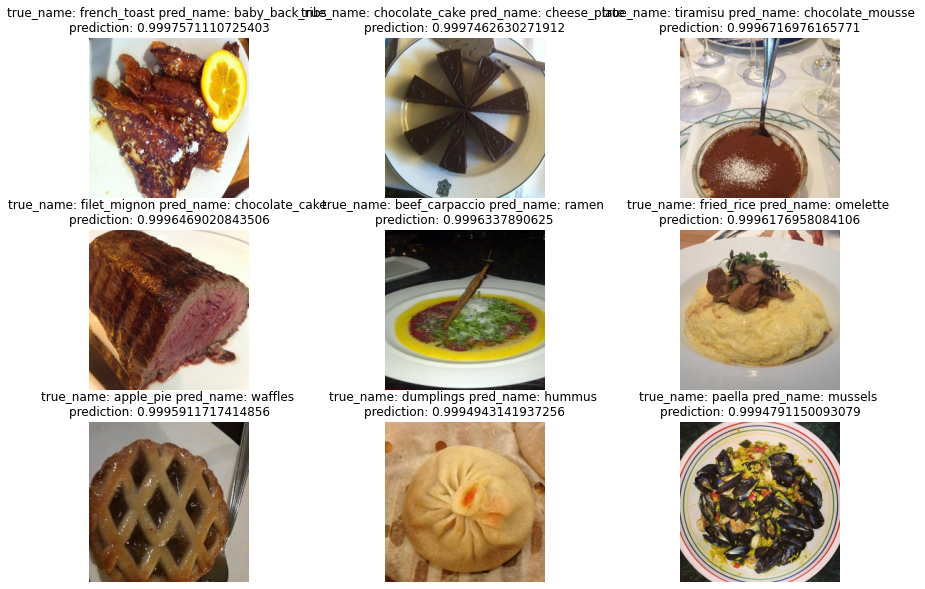

In [246]:
#Visualize the most wrong prediction with higher prediction probability

import matplotlib.pyplot as plt

img_view=9
start_index=20

plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong_exp[start_index: start_index + img_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_pred_image(row[1], scale=False) 
  _, _, _, _,  y_true_class_name,  Y_pred_class_name, Model_prediction, _, = row 

  plt.imshow(img/255.)
  plt.title(f"true_name: {y_true_class_name} pred_name: {Y_pred_class_name} \nprediction: {Model_prediction}")
  plt.axis(False);



In [247]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-06-14 12:46:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-06-14 12:46:37 (93.6 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [254]:
import zipfile
zip_ref= zipfile.ZipFile("custom_food_images.zip")
custom_img_url= zip_ref.extractall()

In [268]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg']

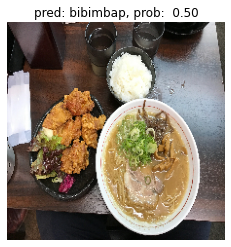

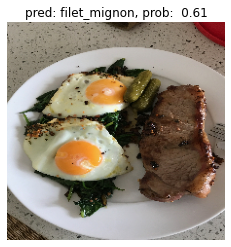

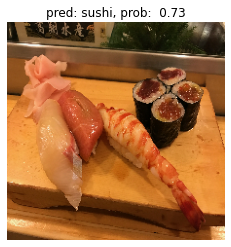

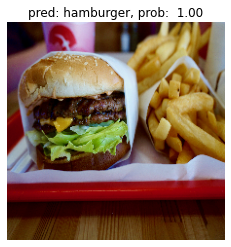

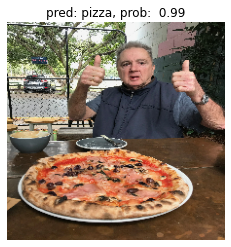

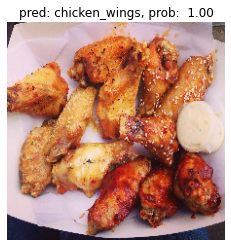

In [277]:

#Make the prediction on custom data
for img in custom_food_images:
  img = load_and_pred_image(img, scale=False)
  pred_prob=model.predict(tf.expand_dims(img, axis=0))
  pred_class=class_names[pred_prob.argmax()]

#Plot the appropriate infomation
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max(): .2f}")
  plt.axis(False)
